In [3]:
# Import Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import random

# Import machine learning libraries
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import joblib

In [4]:
# Load the dataset
old_train_data = pd.read_csv('data/3_old_train_processed.csv')
train_data = pd.read_csv('data/3_train_processed.csv')
train_ros_adta = pd.read_csv('data/3_train_ros_processed.csv')
train_smote_data = pd.read_csv('data/3_train_smote_processed.csv')

# Extract X and y
old_X = old_train_data.drop(['credit_score'], axis=1)
old_y = old_train_data['credit_score']
X = train_data.drop(['credit_score'], axis=1)
X_ros = train_ros_adta.drop(['credit_score'], axis=1)
X_smote = train_smote_data.drop(['credit_score'], axis=1)
y = train_data['credit_score']
y_ros = train_ros_adta['credit_score']
y_smote = train_smote_data['credit_score']

old_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88872 entries, 0 to 88871
Data columns (total 46 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   month                        88872 non-null  int64  
 1   age                          88872 non-null  float64
 2   annual_income                88872 non-null  float64
 3   monthly_inhand_salary        88872 non-null  float64
 4   num_bank_accounts            88872 non-null  float64
 5   num_credit_card              88872 non-null  float64
 6   interest_rate                88872 non-null  float64
 7   num_of_loan                  88872 non-null  float64
 8   delay_from_due_date          88872 non-null  float64
 9   num_of_delayed_payment       88872 non-null  float64
 10  changed_credit_limit         88872 non-null  float64
 11  num_credit_inquiries         88872 non-null  float64
 12  credit_mix                   88872 non-null  int64  
 13  outstanding_debt

In [5]:
def train_and_find_best_model(model, model_name, X, y, metric='Macro F1'):
    print(f"Training {model_name} Model...")
    results = evaluate_model(model, X, y, model_name, best_metric=metric)
    best_model_name = results['Model Name']
    best_model = results['Best Model']
    best_score = results[f'Best {metric}']
    fold_results = results['Fold Results']
    # Drop model
    results_df = pd.DataFrame([results])
    results_df = results_df.drop(columns=['Best Model'])
    print(f"Best Model is {best_model_name}, {metric} = {best_score:.4f}")
    return best_model, best_model_name, results_df, fold_results

def evaluate_model(model, X, y, model_name, best_metric='Macro F1', n=10):
    current_run = 0
    cv = StratifiedKFold(n_splits=n, shuffle=True, random_state=42)
    class_labels = sorted(np.unique(y))
    
    # Performance metrics
    accuracy_scores = []
    precision_macro_scores = []
    recall_macro_scores = []
    f1_macro_scores = []
    roc_auc_scores = []
    fold_results_list = []

    # Best model
    best_model = None
    best_score = -np.inf
    
    # Recall and Precision for each class
    per_class_precision = {cls: [] for cls in class_labels}
    per_class_recall = {cls: [] for cls in class_labels}
    
    for train_idx, test_idx in cv.split(X, y):
        print(f"Fold {current_run + 1}/{n}")
        current_run += 1
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # train the model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Predict probabilities
        y_proba = model.predict_proba(X_test)
        
        # Calculate metrics
        accuracy_score_result = accuracy_score(y_test, y_pred)
        precision_macro_score_result = precision_score(y_test, y_pred, average='macro')
        recall_macro_score_result = recall_score(y_test, y_pred, average='macro')
        f1_macro_score_result = f1_score(y_test, y_pred, average='macro')
        roc_auc_score_result = roc_auc_score(y_test, y_proba, multi_class='ovr')
        
        accuracy_scores.append(accuracy_score_result)
        precision_macro_scores.append(precision_macro_score_result)
        recall_macro_scores.append(recall_macro_score_result)
        f1_macro_scores.append(f1_macro_score_result)
        roc_auc_scores.append(roc_auc_score_result)

        # Compare with the best model
        if best_model is None or f1_macro_score_result > best_score:
            best_model = model
            best_score = f1_macro_score_result
        
        # Calculate per-class precision and recall
        fold_class_metrics = {}
        for cls in class_labels:
            y_test_binary = (y_test == cls)
            y_pred_binary = (y_pred == cls)
            cls_precision = precision_score(y_test_binary, y_pred_binary, zero_division=0)
            cls_recall = recall_score(y_test_binary, y_pred_binary, zero_division=0)
            per_class_precision[cls].append(cls_precision)
            per_class_recall[cls].append(cls_recall)
            fold_class_metrics[f'Class {cls} Precision'] = cls_precision
            fold_class_metrics[f'Class {cls} Recall'] = cls_recall
        
        # Store fold results
        fold_result = {
            'Fold': current_run,
            'Model Name': model_name,
            'Accuracy': accuracy_score_result,
            'Macro Precision': precision_macro_score_result,
            'Macro Recall': recall_macro_score_result,
            'Macro F1': f1_macro_score_result,
            'ROC AUC': roc_auc_score_result,
        }
        fold_result.update(fold_class_metrics)
        fold_results_list.append(fold_result)
    
    # Final Results
    overall_results = {
        'Model Name': model_name,
        'Best Model': best_model,
        f'Best {best_metric}': best_score,
        'Accuracy': np.mean(accuracy_scores),
        'Macro Precision': np.mean(precision_macro_scores),
        'Macro Recall': np.mean(recall_macro_scores),
        'Macro F1': np.mean(f1_macro_scores),
        'ROC AUC': np.mean(roc_auc_scores),
        'Fold Results': fold_results_list 
    }
    
    # Add per-class precision and recall to the overall results
    for cls in class_labels:
        overall_results[f'Class {cls} Precision'] = np.mean(per_class_precision[cls])
        overall_results[f'Class {cls} Recall'] = np.mean(per_class_recall[cls])
    
    return overall_results

def save_best_model(best_model, best_model_name, models_dir='models'):
    if not os.path.exists(models_dir):
        os.makedirs(models_dir)
    
    # Create a filename for the model
    model_filename = f"{best_model_name.replace(' ', '_').lower()}.joblib"
    model_path = os.path.join(models_dir, model_filename)
    # Save the model
    joblib.dump(best_model, model_path)
    print(f"Best Model Saved: {model_path}")
    return model_path

In [6]:
def visualize_results(results_list):
    """Visualize evaluation results for different models"""
    results_df = pd.DataFrame(results_list).set_index('Model Name')
    
    # 1. Main metrics bar chart
    main_metrics = ['Accuracy', 'Macro Precision', 'Macro Recall', 'Macro F1', 'ROC AUC']
    plt.figure(figsize=(14, 7))
    plt.bar = results_df[main_metrics].plot(kind='bar')
    # results_df[main_metrics].plot(kind='bar')
    plt.title('Model Performance Comparison - Main Metrics')
    plt.ylabel('Score')
    # plt.ylim(0, 1)
    plt.xticks(rotation=90)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(loc='best')
    # plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(main_metrics), frameon=True)
    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # 2. Class-specific precision and recall
    class_metrics = [col for col in results_df.columns if 'Class' in col]
    if class_metrics:
        plt.figure(figsize=(14, 7))
        sns.heatmap(results_df[class_metrics], annot=True, cmap='YlGnBu', fmt='.3f')
        plt.title('Precision and Recall by Class')
        plt.tight_layout()
        plt.show()
    
    # 3. Comprehensive score
    results_df['Comprehensive Score'] = 0.5 * results_df['Macro F1'] + 0.5 * results_df['Accuracy']
    plt.figure(figsize=(10, 5))
    results_df['Comprehensive Score'].sort_values().plot(kind='barh', figsize=(10, 5))
    plt.title('Model Performance - Comprehensive Score')
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.show()
    
    return results_df

# Initialize models
models = [
    (LogisticRegression(max_iter=10000, random_state=42), 'Logistic Regression'),
    (xgb.XGBClassifier(random_state=42), 'XGBoost')
]

In [7]:
# Seed
seed = 42
random.seed(seed)
np.random.seed(seed)

# Logistic Regression
logistic_model, logistic_model_name = LogisticRegression(max_iter=100000, random_state=42), 'Logistic Regression'
logistic_model, logistic_model_name, logistic_results_df, logistic_fold_results= train_and_find_best_model(logistic_model, logistic_model_name, X, y, metric='Macro F1')
logistic_model_path = save_best_model(logistic_model, logistic_model_name)
# ROS
logistic_model_ros, logistic_model_name_ros = LogisticRegression(max_iter=100000, random_state=42), 'Logistic Regression ROS'
logistic_model_ros, logistic_model_name_ros, logistic_results_ros_df, logistic_fold_results_ros = train_and_find_best_model(logistic_model_ros, logistic_model_name_ros, X_ros, y_ros, metric='Macro F1')
logistic_model_ros_path = save_best_model(logistic_model_ros, logistic_model_name_ros)
# SMOTE
logistic_model_smote, logistic_model_name_smote = LogisticRegression(max_iter=100000, random_state=42), 'Logistic Regression SMOTE'
logistic_model_smote, logistic_model_name_smote, logistic_results_smote_df, logistic_fold_results_smote = train_and_find_best_model(logistic_model_smote, logistic_model_name_smote, X_smote, y_smote, metric='Macro F1')
logistic_model_smote_path = save_best_model(logistic_model_smote, logistic_model_name_smote)

# XGBoost
xgb_model, xgb_model_name = xgb.XGBClassifier(random_state=42), 'XGBoost'
xgb_model, xgb_model_name, xgb_results_df, xgb_fold_results = train_and_find_best_model(xgb_model, xgb_model_name, X, y, metric='Macro F1')
xgb_model_path = save_best_model(xgb_model, xgb_model_name)
# ROS
xgb_model_ros, xgb_model_name_ros = xgb.XGBClassifier(random_state=42), 'XGBoost ROS'
xgb_model_ros, xgb_model_name_ros, xgb_results_ros_df, xgb_fold_results_ros = train_and_find_best_model(xgb_model_ros, xgb_model_name_ros, X_ros, y_ros, metric='Macro F1')
xgb_model_ros_path = save_best_model(xgb_model_ros, xgb_model_name_ros)
# SMOTE
xgb_model_smote, xgb_model_name_smote = xgb.XGBClassifier(random_state=42), 'XGBoost SMOTE'
xgb_model_smote, xgb_model_name_smote, xgb_results_smote_df, xgb_fold_results_smote = train_and_find_best_model(xgb_model_smote, xgb_model_name_smote, X_smote, y_smote, metric='Macro F1')
xgb_model_smote_path = save_best_model(xgb_model_smote, xgb_model_name_smote)

# Combine results
logistic_results = pd.concat([logistic_results_df, logistic_results_ros_df, logistic_results_smote_df], axis=0)
xgb_results = pd.concat([xgb_results_df, xgb_results_ros_df, xgb_results_smote_df], axis=0)

# Combine results
original_results = pd.concat([logistic_results_df, xgb_results_df], axis=0)
ros_results = pd.concat([logistic_results_ros_df, xgb_results_ros_df], axis=0)
smote_results = pd.concat([logistic_results_smote_df, xgb_results_smote_df], axis=0)

Training Logistic Regression Model...
Fold 1/10
Fold 2/10
Fold 3/10
Fold 4/10
Fold 5/10
Fold 6/10
Fold 7/10
Fold 8/10
Fold 9/10
Fold 10/10
Best Model is Logistic Regression, Macro F1 = 0.6391
Best Model Saved: models/logistic_regression.joblib
Training Logistic Regression ROS Model...
Fold 1/10
Fold 2/10
Fold 3/10
Fold 4/10
Fold 5/10
Fold 6/10
Fold 7/10
Fold 8/10
Fold 9/10
Fold 10/10
Best Model is Logistic Regression ROS, Macro F1 = 0.7015
Best Model Saved: models/logistic_regression_ros.joblib
Training Logistic Regression SMOTE Model...
Fold 1/10
Fold 2/10
Fold 3/10
Fold 4/10
Fold 5/10
Fold 6/10
Fold 7/10
Fold 8/10
Fold 9/10
Fold 10/10
Best Model is Logistic Regression SMOTE, Macro F1 = 0.7285
Best Model Saved: models/logistic_regression_smote.joblib
Training XGBoost Model...
Fold 1/10
Fold 2/10
Fold 3/10
Fold 4/10
Fold 5/10
Fold 6/10
Fold 7/10
Fold 8/10
Fold 9/10
Fold 10/10
Best Model is XGBoost, Macro F1 = 0.7731
Best Model Saved: models/xgboost.joblib
Training XGBoost ROS Model...


In [8]:
final_fold_results_df = pd.concat([pd.DataFrame(logistic_fold_results), pd.DataFrame(logistic_fold_results_ros), pd.DataFrame(logistic_fold_results_smote), pd.DataFrame(xgb_fold_results), pd.DataFrame(xgb_fold_results_ros), pd.DataFrame(xgb_fold_results_smote)], axis=0)
final_fold_results_df.to_csv('data/4_final_fold_results.csv', index=False)
final_fold_results_df

,Fold,Model Name,Accuracy,Macro Precision,Macro Recall,Macro F1,ROC AUC,Class 0.0 Precision,Class 0.0 Recall,Class 1.0 Precision,Class 1.0 Recall,Class 2.0 Precision,Class 2.0 Recall
0,1,Logistic Regression,0.662447,0.642660,0.635844,0.634841,0.815304,0.694526,0.540293,0.687931,0.747391,0.545522,0.619849
1,2,Logistic Regression,0.648805,0.629192,0.624645,0.623378,0.811437,0.672206,0.537088,0.674789,0.726251,0.540581,0.610597
2,3,Logistic Regression,0.654149,0.633419,0.631316,0.629259,0.811161,0.670601,0.546496,0.683325,0.728124,0.546331,0.619328
3,4,Logistic Regression,0.655274,0.635565,0.631775,0.631068,0.809459,0.663889,0.547412,0.682591,0.730265,0.560213,0.617647
4,5,Logistic Regression,0.652461,0.633642,0.631076,0.628585,0.808803,0.671461,0.534585,0.678803,0.728392,0.550661,0.630252
5,6,Logistic Regression,0.667229,0.648072,0.636790,0.639103,0.818342,0.697595,0.557692,0.688372,0.752677,0.558249,0.600000
6,7,Logistic Regression,0.660338,0.640918,0.636118,0.634445,0.816665,0.683353,0.537546,0.686556,0.742238,0.552846,0.628571
7,8,Logistic Regression,0.651287,0.631882,0.623944,0.623940,0.814761,0.666862,0.520604,0.676694,0.740632,0.552091,0.610597
8,9,Logistic Regression,0.651006,0.629906,0.627827,0.625117,0.810023,0.680754,0.545788,0.680322,0.724572,0.528644,0.613120
9,10,Logistic Regression,0.651287,0.632062,0.628146,0.626266,0.809271,0.665701,0.526099,0.678147,0.732602,0.552339,0.625736


In [5]:
import pandas as pd
# Get average training results
final_fold_results_df = pd.read_csv('./data/4_final_fold_results.csv')
final_fold_results_df = final_fold_results_df.groupby(['Model Name']).mean().reset_index()
print(final_fold_results_df)

                  Model Name  Fold  Accuracy  Macro Precision  Macro Recall  \
0        Logistic Regression   5.5  0.655428         0.635732      0.630748   
1    Logistic Regression ROS   5.5  0.699139         0.697467      0.699139   
2  Logistic Regression SMOTE   5.5  0.722994         0.722898      0.722994   
3                    XGBoost   5.5  0.778598         0.763308      0.769266   
4                XGBoost ROS   5.5  0.832838         0.833173      0.832838   
5              XGBoost SMOTE   5.5  0.841358         0.840638      0.841358   

   Macro F1   ROC AUC  Class 0.0 Precision  Class 0.0 Recall  \
0  0.629600  0.812523             0.676695          0.539360   
1  0.696100  0.827098             0.730931          0.686819   
2  0.718827  0.858841             0.746784          0.672501   
3  0.766112  0.910085             0.778071          0.768925   
4  0.829113  0.937470             0.836693          0.872956   
5  0.839724  0.950449             0.845905          0.850154  

<Figure size 1400x700 with 0 Axes>

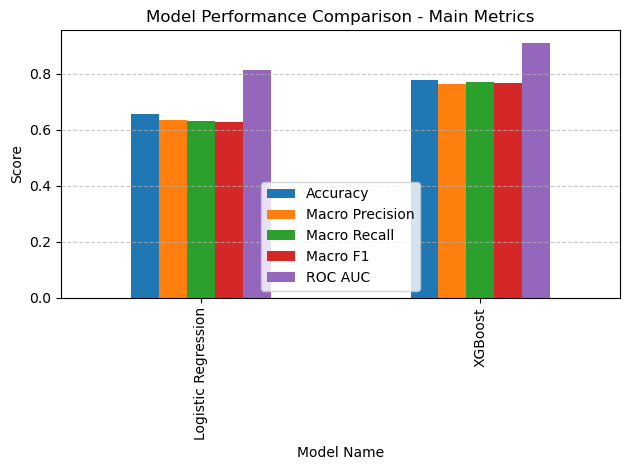

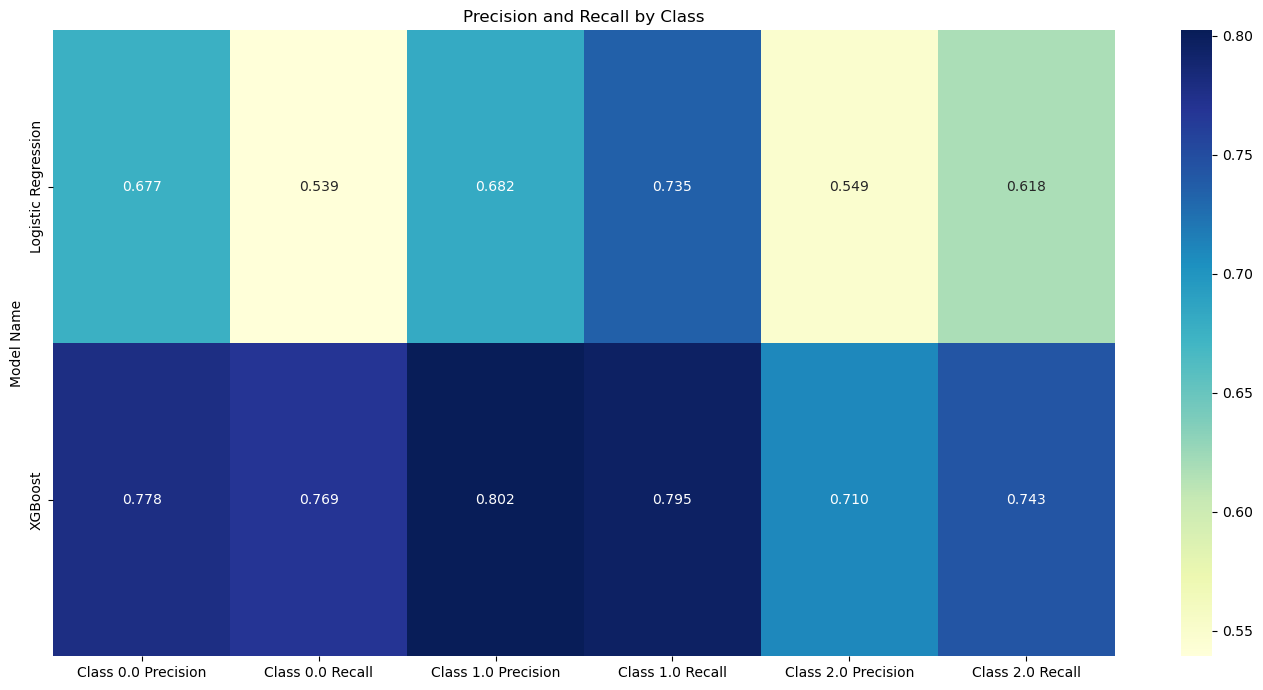

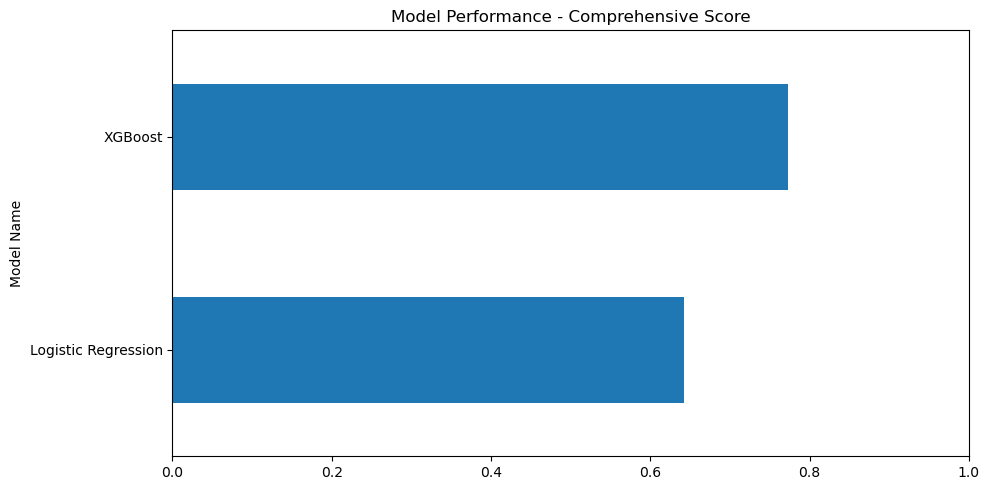

Detailed Evaluation Metrics:


,Best Macro F1,Accuracy,Macro Precision,Macro Recall,Macro F1,ROC AUC,Fold Results,Class 0.0 Precision,Class 0.0 Recall,Class 1.0 Precision,Class 1.0 Recall,Class 2.0 Precision,Class 2.0 Recall,Comprehensive Score
Model Name,,,,,,,,,,,,,,
Logistic Regression,0.639103,0.655428,0.635732,0.630748,0.629600,0.812523,"[{'Fold': 1, 'Model Name': 'Logistic Regressio...",0.676695,0.539360,0.681753,0.735314,0.548748,0.617570,0.642514
XGBoost,0.773094,0.778598,0.763308,0.769266,0.766112,0.910085,"[{'Fold': 1, 'Model Name': 'XGBoost', 'Accurac...",0.778071,0.768925,0.802207,0.795451,0.709647,0.743423,0.772355


In [9]:
results_df = visualize_results(original_results)

# Display the results
print("Detailed Evaluation Metrics:")
display(results_df)

<Figure size 1400x700 with 0 Axes>

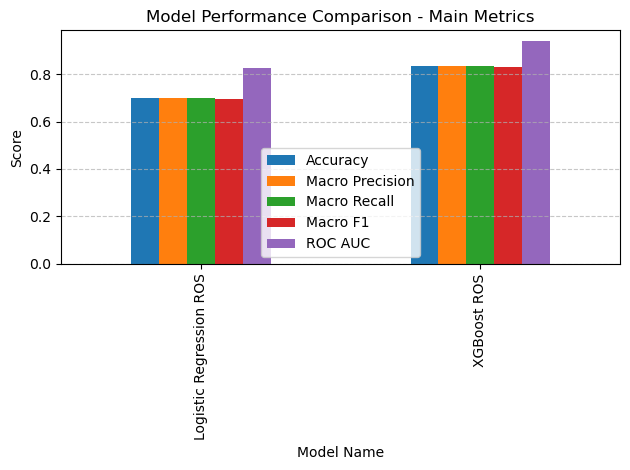

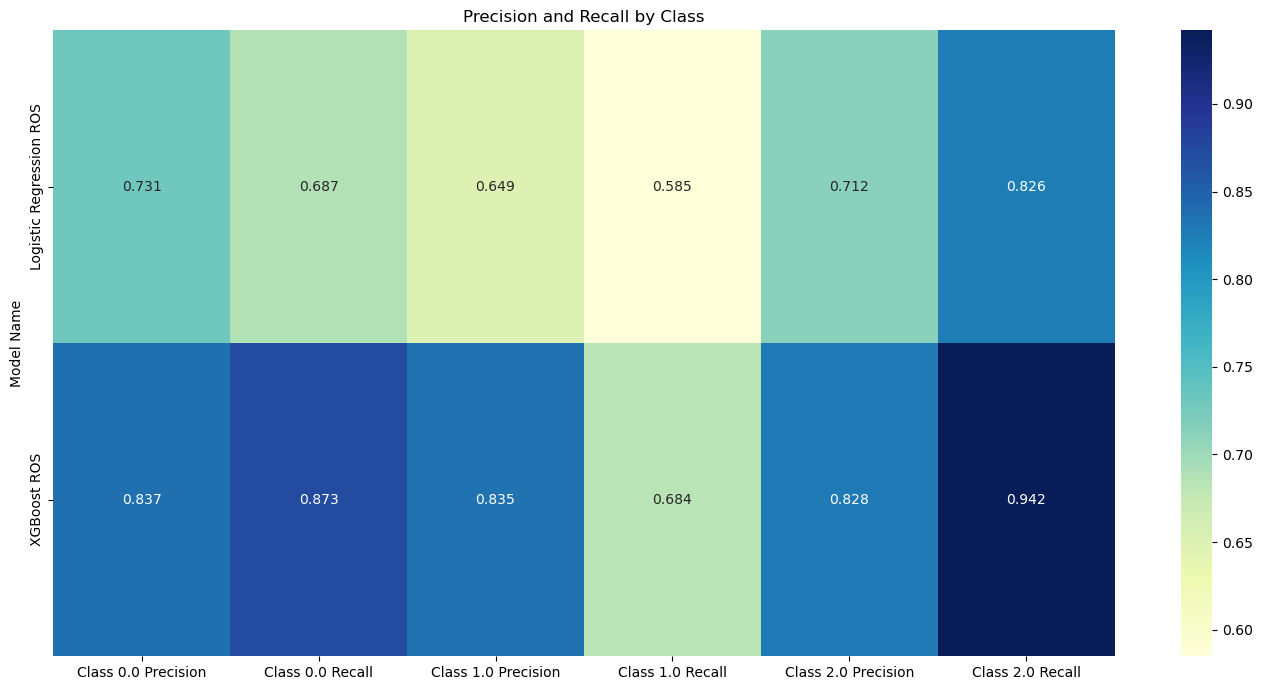

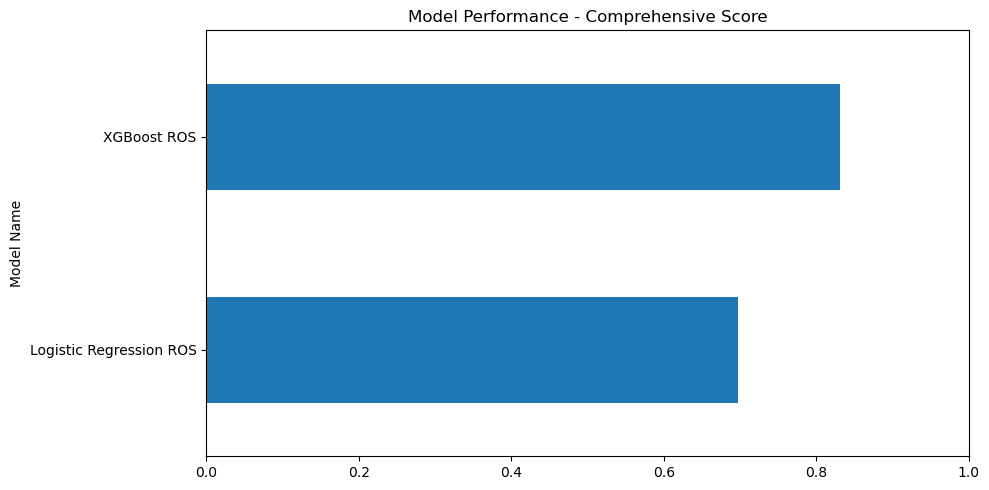

Detailed Evaluation Metrics:


,Best Macro F1,Accuracy,Macro Precision,Macro Recall,Macro F1,ROC AUC,Fold Results,Class 0.0 Precision,Class 0.0 Recall,Class 1.0 Precision,Class 1.0 Recall,Class 2.0 Precision,Class 2.0 Recall,Comprehensive Score
Model Name,,,,,,,,,,,,,,
Logistic Regression ROS,0.701453,0.699139,0.697467,0.699139,0.696100,0.827098,"[{'Fold': 1, 'Model Name': 'Logistic Regressio...",0.730931,0.686819,0.649272,0.584853,0.712199,0.825746,0.697620
XGBoost ROS,0.836002,0.832838,0.833173,0.832838,0.829113,0.937470,"[{'Fold': 1, 'Model Name': 'XGBoost ROS', 'Acc...",0.836693,0.872956,0.835098,0.683581,0.827729,0.941978,0.830976


In [10]:
results_ros_df = visualize_results(ros_results)

# Display the results
print("Detailed Evaluation Metrics:")
display(results_ros_df)

<Figure size 1400x700 with 0 Axes>

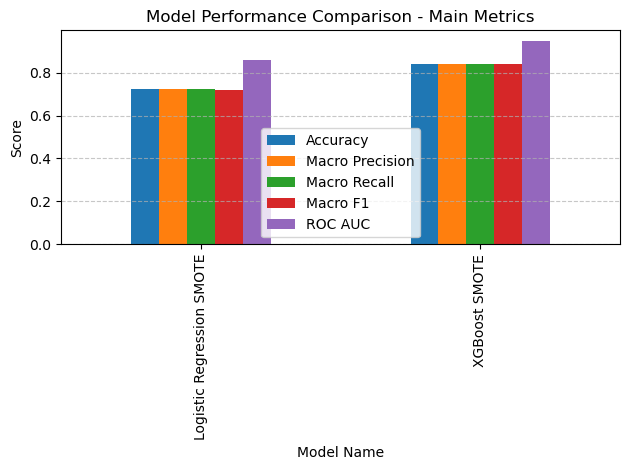

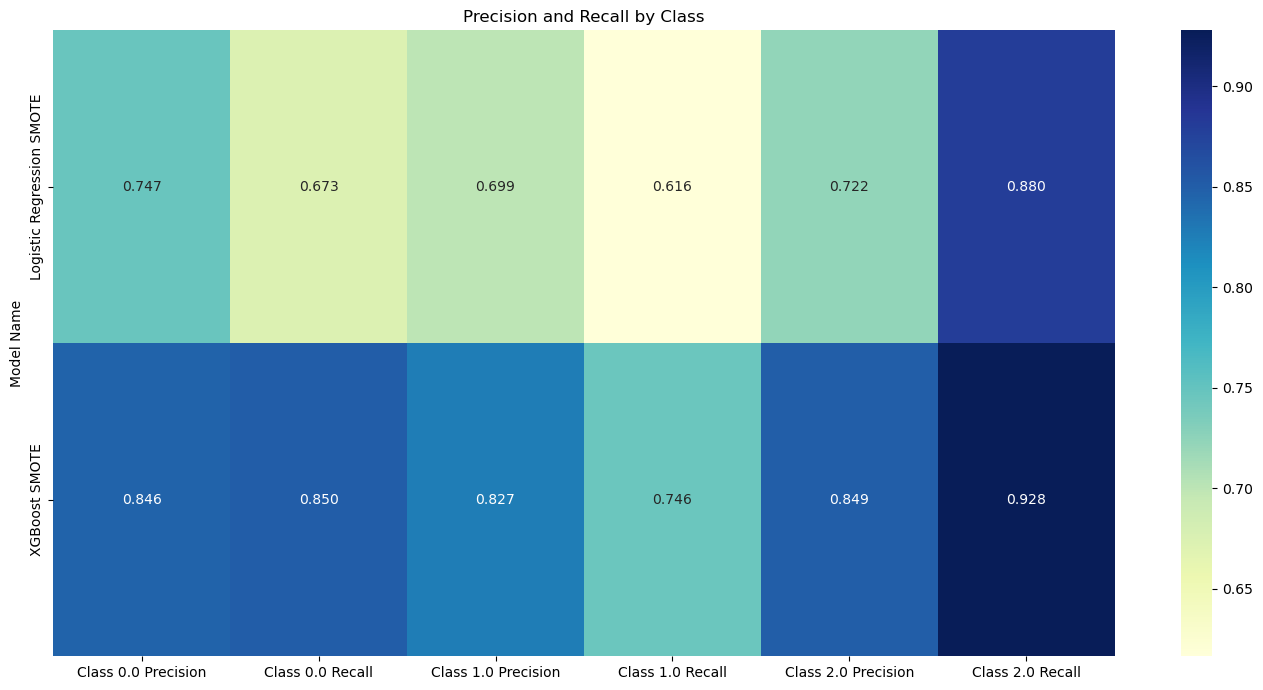

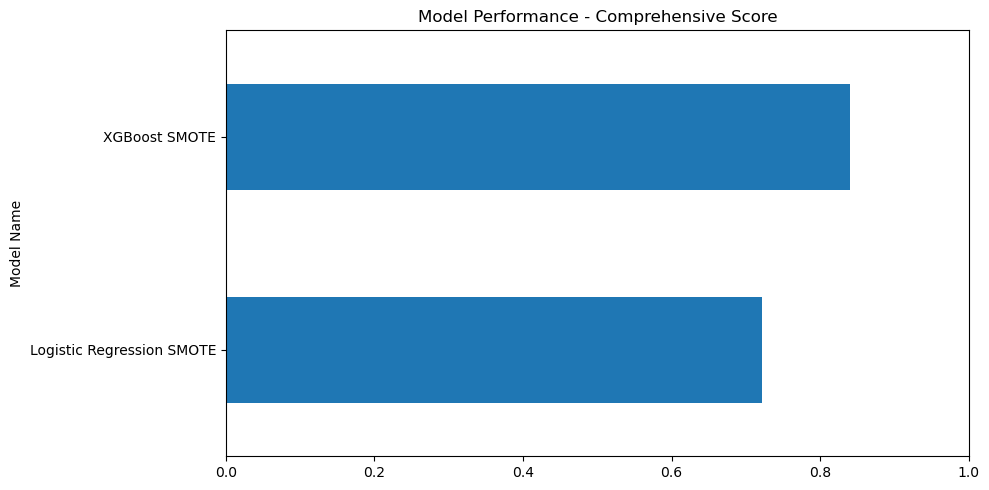

Detailed Evaluation Metrics:


,Best Macro F1,Accuracy,Macro Precision,Macro Recall,Macro F1,ROC AUC,Fold Results,Class 0.0 Precision,Class 0.0 Recall,Class 1.0 Precision,Class 1.0 Recall,Class 2.0 Precision,Class 2.0 Recall,Comprehensive Score
Model Name,,,,,,,,,,,,,,
Logistic Regression SMOTE,0.728479,0.722994,0.722898,0.722994,0.718827,0.858841,"[{'Fold': 1, 'Model Name': 'Logistic Regressio...",0.746784,0.672501,0.699431,0.616433,0.722478,0.880048,0.720911
XGBoost SMOTE,0.844127,0.841358,0.840638,0.841358,0.839724,0.950449,"[{'Fold': 1, 'Model Name': 'XGBoost SMOTE', 'A...",0.845905,0.850154,0.826633,0.746099,0.849376,0.927820,0.840541


In [11]:
results_smote_df = visualize_results(smote_results)

# Display the results
print("Detailed Evaluation Metrics:")
display(results_smote_df)

In [12]:
# Load the test data
test_data = pd.read_csv('data/3_test_processed.csv')
feature = test_data.drop(['credit_score'], axis=1)
target = test_data['credit_score']

# Load the best model
logistic_model = joblib.load(logistic_model_path)
logistic_model_ros = joblib.load(logistic_model_ros_path)
logistic_model_smote = joblib.load(logistic_model_smote_path)
xgb_model = joblib.load(xgb_model_path)
xgb_model_ros = joblib.load(xgb_model_ros_path)
xgb_model_smote = joblib.load(xgb_model_smote_path)

# Evaluate the models on the test data
def evaluate_model_on_test_data(model, X, y, model_name):
    """Evaluate the model on the test data and print the results"""
    results = []
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='macro')
    recall = recall_score(y, y_pred, average='macro')
    f1 = f1_score(y, y_pred, average='macro')
    roc_auc = roc_auc_score(y, model.predict_proba(X), multi_class='ovr')

    results.append({
        'Model Name': model_name,
        'Accuracy': accuracy,
        'Macro Precision': precision,
        'Macro Recall': recall,
        'Macro F1': f1,
        'ROC AUC': roc_auc
    })
    return pd.DataFrame(results)

# Evaluate the models on the test data
logistic_results_test = evaluate_model_on_test_data(logistic_model, feature, target, 'Logistic Regression')
logistic_results_ros_test = evaluate_model_on_test_data(logistic_model_ros, feature, target, 'Logistic Regression ROS')
logistic_results_smote_test = evaluate_model_on_test_data(logistic_model_smote, feature, target, 'Logistic Regression SMOTE')
xgb_results_test = evaluate_model_on_test_data(xgb_model, feature, target, 'XGBoost')
xgb_results_ros_test = evaluate_model_on_test_data(xgb_model_ros, feature, target, 'XGBoost ROS')
xgb_results_smote_test = evaluate_model_on_test_data(xgb_model_smote, feature, target, 'XGBoost SMOTE')

# Combine test results
test_results = pd.concat([logistic_results_test, logistic_results_ros_test, logistic_results_smote_test,
                           
                           xgb_results_test, xgb_results_ros_test, xgb_results_smote_test], axis=0)
test_results

,Model Name,Accuracy,Macro Precision,Macro Recall,Macro F1,ROC AUC
0,Logistic Regression,0.656990,0.638091,0.628825,0.629908,0.811709
0,Logistic Regression ROS,0.654177,0.635376,0.690144,0.645577,0.806847
0,Logistic Regression SMOTE,0.656653,0.634972,0.681372,0.644701,0.802670
0,XGBoost,0.745654,0.728202,0.737928,0.731905,0.892101
0,XGBoost ROS,0.699297,0.677376,0.727963,0.691014,0.868614
0,XGBoost SMOTE,0.574909,0.633945,0.693544,0.572288,0.849304


In [13]:
test_results.to_csv('data/4_test_results.csv', index=False)

In [6]:
import pandas as pd
test_results = pd.read_csv('data/4_test_results.csv')
print(test_results)

                  Model Name  Accuracy  Macro Precision  Macro Recall  \
0        Logistic Regression  0.656990         0.638091      0.628825   
1    Logistic Regression ROS  0.654177         0.635376      0.690144   
2  Logistic Regression SMOTE  0.656653         0.634972      0.681372   
3                    XGBoost  0.745654         0.728202      0.737928   
4                XGBoost ROS  0.699297         0.677376      0.727963   
5              XGBoost SMOTE  0.574909         0.633945      0.693544   

   Macro F1   ROC AUC  
0  0.629908  0.811709  
1  0.645577  0.806847  
2  0.644701  0.802670  
3  0.731905  0.892101  
4  0.691014  0.868614  
5  0.572288  0.849304  
